# Info about Project

### Model Notes
- Find useful information about MobileNet [here](https://pytorch.org/vision/main/models/mobilenetv3.html) or [here.](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_mobilenet_v3_large.html)

### Dataset Notes
**Retinal Image Dataset**
- Dataset can be found [here.](https://www.kaggle.com/datasets/ipythonx/retinal-vessel-segmentation) ***File size = 648.3 MB***
- Contains two mask types: Eye mask, and Retina mask.
- Only working with data in CHASE_DB1, and HRF
- Every single image in `CHASE_DB1/Images` has two masks in `CHASE_DB1/Masks`
- The masks within `CHASE_DB1/Masks` are represented as True/False **and not** 1/0

**Lung Segmentation Dataset**
- The dataset can be found or [here](https://github.com/IlliaOvcharenko/lung-segmentation/tree/master) or directly through this [link.](https://drive.google.com/file/d/1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ/view?usp=sharing) ***File size = 4.19GB***

**Skin Lesion Segmentation Dataset**
- The dataset can be found or [here](https://challenge.isic-archive.com/data/#2017) or directly through this [link.](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip) The masks here are in superpixel format ***File size = 5.8GB***. Binary masks can be found [here](https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip) ***File size = 9MB***

# Importing Important Libraries

In [134]:
# File System Handling
import os
import gc
import gdown
import tarfile
import zipfile

# Data Processing
import cv2
import tifffile
import requests
import numpy as np
import pandas as pd
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Model Training, evaluation processes...
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

# Handling OutOfMemoryError
import multiprocessing
multiprocessing.set_start_method("spawn", force = True)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

#########################################
import torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')
######################################### Re-run and change num workers back to >1.

print("All libraries succesfully imported, with configorations implemented.")

All libraries succesfully imported, with configorations implemented.


# Organizing Train images path

## Image Paths or Url

In [2]:
# Declaring all paths, and URLs.

# **Retina Images**
EYE_IMAGES_1 = r"./Datasets/retina/CHASE_DB1/Images/"
EYE_IMAGES_2 = r"./Datasets/retina/HRF/images/"

EYE_MASKS_1 = r"./Datasets/retina/CHASE_DB1/Masks/"
EYE_MASKS_2 = r"./Datasets/retina/HRF/manual1/"

# **Lungs Images**
# Sharing URL modified to Download URL
# FROM THIS FORMAT BELOW
# https://drive.google.com/file/d/FILE_ID/view?usp=sharing
# TO THIS FORMAT BELOW
# https://drive.google.com/uc?export=download&id=FILE_ID
LUNG_IMAGES = "https://drive.google.com/uc?export=download&id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ"
LUNG_BASE_DIR = r"./Datasets/lungs/"
LUNG_IMAGES_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "images")
LUNG_MASKS_DIR = os.path.join(LUNG_BASE_DIR, "dataset", "masks")

# **Skin Lesion Images**
SKIN_LESION_BASE_DIR = r"./Datasets/skin_lesion/"
SKIN_LESION_IMAGES = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
SKIN_LESION_BINARY_MASKS = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"

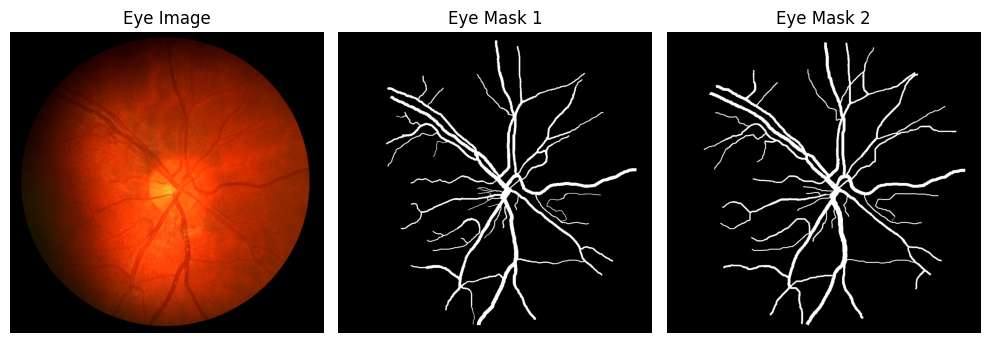

In [73]:
# Sample of an image an eye image and its two labels.
# Notice how they slightly differ?
# I have included both samples in training data as some form of augmentation.

# 0 > i < 14
i = "14" # Adjust to see different images. Numbers below 10 start with 0 e.g "02"

plt.subplots(1,3, figsize = (10,10))

plt.subplot(1,3,1)
plt.title("Eye Image")
im = Image.open(os.path.join(EYE_IMAGES_1, rf"Image_{i}R.jpg"))
plt.imshow(im)
plt.axis(False);

plt.subplot(1,3,2)
plt.title("Eye Mask 1")
im = Image.open(os.path.join(EYE_MASKS_1, rf"Image_{i}R_1stHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray')

plt.subplot(1,3,3)
plt.title("Eye Mask 2")
im = Image.open(os.path.join(EYE_MASKS_1, rf"Image_{i}R_2ndHO.png"))
plt.axis(False)
plt.imshow(im, cmap='gray');
plt.tight_layout();

### Retina Images

In [155]:
# ============== Sorting Images and masks in CHASE_DB1 ============== #
image_paths = [] # list of images.
mask_paths = [] # list of corresponding image masks.

count = 0

for image in os.listdir(EYE_IMAGES_1): # Looping through every image
    image_masks = [] # List to store the two mask paths per image
    
    for mask in os.listdir(EYE_MASKS_1): # Looping through all masks
        if image[:9] in mask: # Checking if mask name has image name in it
            image_paths.append(os.path.join(EYE_IMAGES_1, image)) # Adding image path
            mask_paths.append(os.path.join(EYE_MASKS_1, mask)) # Adding corresponding mask path
            
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# ============== Sorting Images and masks in HRF ============== #
retina_image_paths = sorted(image_paths + [os.path.join(EYE_IMAGES_2, path) for path in os.listdir(EYE_IMAGES_2)])
retina_mask_paths = sorted(mask_paths + [os.path.join(EYE_MASKS_2, path) for path in os.listdir(EYE_MASKS_2)])

print(f"Rentina:\nThere are {len(retina_image_paths)} images, and {len(retina_mask_paths)} masks.")

Rentina:
There are 101 images, and 101 masks.


### Lungs Images

In [6]:
# DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# Creating base dir for lung images
os.makedirs(LUNG_BASE_DIR, exist_ok = True)

# Downloading dataset.
gdown.download(LUNG_IMAGES, LUNG_BASE_DIR, quiet = False)
print("Download completed.")

# Finding file.
zipped_file_name = [file.name for file in os.scandir(LUNG_BASE_DIR)][0]

# Extracting downloaded dataset
with tarfile.open(os.path.join(LUNG_BASE_DIR, zipped_file_name), "r:gz") as zip_ref:
    zip_ref.extractall(LUNG_BASE_DIR)
print("Image zip file content extracted")
    
# Deleting zipped file
os.remove(os.path.join(LUNG_BASE_DIR, zipped_file_name))
print("Zipped file deleted.")

In [156]:
# Sorting Train Image Paths... Extracting first 704 lung images because there are only 704 masks.
lung_image_paths = sorted([os.path.join(LUNG_IMAGES_DIR, path) for path in os.listdir(LUNG_IMAGES_DIR)])
lung_mask_paths = sorted([os.path.join(LUNG_MASKS_DIR, path) for path in os.listdir(LUNG_MASKS_DIR)])

print(f"Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

masks = []
images = []

for image in os.listdir(LUNG_IMAGES_DIR):
    for mask in os.listdir(LUNG_MASKS_DIR):
        if image.split(".")[0] in mask.split(".")[0]:
            images.append(os.path.join(LUNG_IMAGES_DIR, image))
            masks.append(os.path.join(LUNG_MASKS_DIR, mask))

lung_image_paths = sorted(images)
lung_mask_paths = sorted(masks)

print(f"Matching Lungs:\nThere are {len(lung_image_paths)} images, and {len(lung_mask_paths)} masks.")

Lungs:
There are 800 images, and 704 masks.
Matching Lungs:
There are 704 images, and 704 masks.


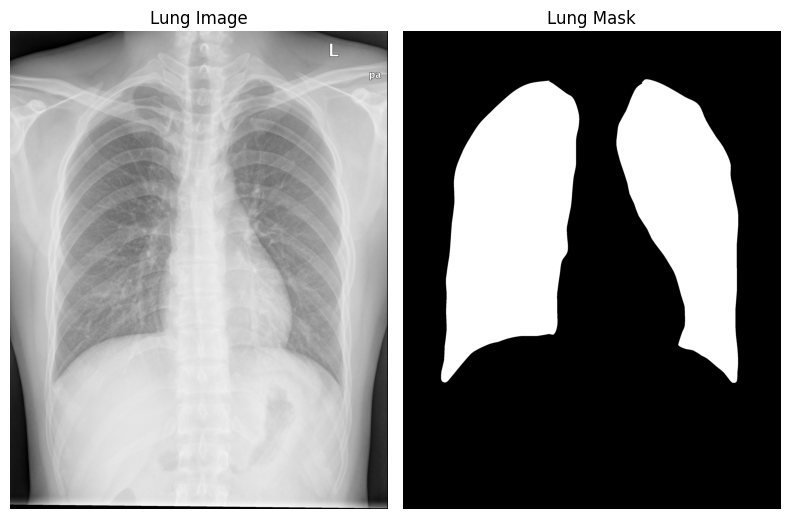

In [16]:
# Sample of a lung image and label.

# 0 >= i <= 703
i = 240 # Adjust to see different images.

plt.subplots(1,2, figsize = (8,10))

plt.subplot(1,2,1)
plt.title("Lung Image")
im = Image.open(lung_image_paths[i])
plt.imshow(im, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lung Mask")
im = Image.open(lung_mask_paths[i])
plt.axis(False)
plt.imshow(im, cmap = "gray")

plt.tight_layout();

### Skin lesion Images

In [9]:
# DO NOT RE-RUN UNLESS DATASET NOT ALREADY DOWNLOADED, AND SORTED.

# Creating base dir for lung images
os.makedirs(SKIN_LESION_BASE_DIR, exist_ok = True)

# Downloading dataset.
response = requests.get(SKIN_LESION_IMAGES, stream = True)

with open(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"), 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)
print("Download completed.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(SKIN_LESION_BASE_DIR,'ISIC-2017_Training_Data'))
print("Image zip file content extracted")
    
# Deleting zipped file
os.remove(os.path.join(SKIN_LESION_BASE_DIR, "dataset.zip"))
print("Zipped file deleted.")

# Downloading binary masks.
response = requests.get(SKIN_LESION_BINARY_MASKS, stream = True)
with open(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"), 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)
print("Download completed.")

# Extract the contents of the zip file
with zipfile.ZipFile(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(SKIN_LESION_BASE_DIR, "2017_Training_Part1_GroundTruth"))
print("Image zip file content extracted")

os.remove(os.path.join(SKIN_LESION_BASE_DIR, "bin_mask.zip"))
print("Zipped file deleted.")


# Moving csv file out to avoid mismatch issues later.
os.rename(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data", "ISIC-2017_Training_Data_metadata.csv"), os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
print("CSV moved to desired location.")

In [6]:
csv_ = pd.read_csv(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data_metadata.csv"))
csv_.head()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male


In [157]:
#  -------------------->    ***TEMPORARY***: RE-RUN THIS CELL N-TIMES TILL TRAINING, AND TEST IMAGES = 2,000.     <--------------------

# Sorting Train Image Paths
lesion_image_paths = []
lesion_mask_paths = []

# ADJUST BAD LOGIC HERE LATER ;)
# RUN THIS ABOUT 3 TIMES TO HAVE THE FULL DATASET.
for path, bin_path in zip(
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "ISIC-2017_Training_Data", "ISIC-2017_Training_Data")),
    os.scandir(os.path.join(SKIN_LESION_BASE_DIR, "2017_Training_Part1_GroundTruth", "ISIC-2017_Training_Part1_GroundTruth"))
):
    # Adding all binary label paths to list.
    lesion_mask_paths.append(bin_path.path)
    
    if path.name.endswith("jpg"): # Checking if the picture is jpg meaning image (superpixel masks)
        lesion_image_paths.append(path.path) # Adding all image paths to list
    
    elif path.name.endswith("png"): # Deleting "superpixel masks"
        os.remove(path.path)
        
# Sorting both lists so that images and labels match.
lesion_image_paths, lesion_mask_paths = sorted(lesion_image_paths), sorted(lesion_mask_paths)

print(f"Skin Lesion:\nThere are {len(lesion_image_paths)} images, and {len(lesion_mask_paths)} masks.")

Skin Lesion:
There are 2000 images, and 2000 masks.


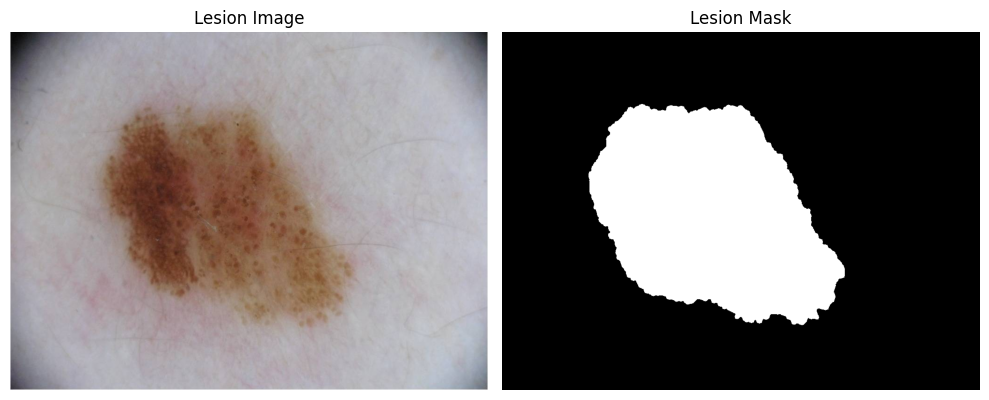

In [158]:
# Sample of a lesion image and label.

# 0 >= i <= 1999
i = 8 # Adjust to see different images.

plt.subplots(1,2, figsize = (10,10))

plt.subplot(1,2,1)
plt.title("Lesion Image")
image = Image.open(lesion_image_paths[i])
plt.imshow(image, cmap = "gray")
plt.axis(False);

plt.subplot(1,2,2)
plt.title("Lesion Mask")
mask = Image.open(lesion_mask_paths[i])
plt.axis(False)
plt.imshow(mask, cmap = "gray")

plt.tight_layout();

# Data Pre-processing & Augmentation

In [162]:
# Defining Standardz.
IMAGE_SIZE = (512, 512) # As seen on website. -> 520 for mobile net.
BATCH_SIZE = 2
BIN_THRESHOLD = 0.7 # For probabilities to class.
TEST_SIZE = 0.1 # Percentage of data to use for testing.
VAL_SIZE = 0.1 # Percentage of data to use for evaluation (During Training).
NUM_CLASSES = 1 # 2 because it is class against background.
R_FULL = len(retina_image_paths) # Retina full data amount 
LU_FULL = len(lung_image_paths) # Lungs full data amount
LE_FULL = len(lesion_image_paths) # Lesion full data amount

# Calculating TEST_SIZE, and VAL_SIZE for each data set.
retina_v_per = int(len(retina_image_paths) * VAL_SIZE) # Validation size
lung_v_per = int(len(lung_image_paths) * VAL_SIZE) # Validation size
lesion_v_per = int(len(lesion_image_paths) * VAL_SIZE) # Validation size

retina_t_per = int(len(retina_image_paths) * TEST_SIZE) # Test size
lung_t_per = int(len(lung_image_paths) * TEST_SIZE) # Test size
lesion_t_per = int(len(lesion_image_paths) * TEST_SIZE) # Test size

# Extracting Training, Test, and Validation data... Extracting first, and last n file paths.
retina_train_images, retina_train_masks = retina_image_paths[:R_FULL - (retina_v_per + retina_t_per)], retina_mask_paths[:R_FULL - (retina_v_per + retina_t_per)] # First "n" file paths
retina_val_images, retina_val_masks = retina_image_paths[- (retina_v_per + retina_t_per): - retina_t_per], retina_mask_paths[- (retina_v_per + retina_t_per): - retina_t_per] # Next "n" starting at first n + 1 and stopping before last.
retina_test_images, retina_test_masks = retina_image_paths[- retina_t_per:], retina_mask_paths[- retina_t_per:] # Last "n"

lung_train_images, lung_train_masks = lung_image_paths[:LU_FULL - (lung_v_per + lung_t_per)], lung_mask_paths[:LU_FULL - (lung_v_per + lung_t_per)] # First "n" file paths
lung_val_images, lung_val_masks = lung_image_paths[- (lung_v_per + lung_t_per): - lung_t_per], lung_mask_paths[- (lung_v_per + lung_t_per): - lung_t_per] # Next "n" starting at first n + 1 and stopping before last.
lung_test_images, lung_test_masks = lung_image_paths[- lung_t_per:], lung_mask_paths[- lung_t_per:] # Last "n"

lesion_train_images, lesion_train_masks = lesion_image_paths[:LE_FULL - (lesion_v_per + lesion_t_per)], lesion_mask_paths[:LE_FULL - (lesion_v_per + lesion_t_per)] # First "n" file paths
lesion_val_images, lesion_val_masks = lesion_image_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per], lesion_mask_paths[- (lesion_v_per + lesion_t_per): - lesion_t_per] # Next "n" starting at first n + 1 and stopping before last.
lesion_test_images, lesion_test_masks = lesion_image_paths[- lesion_t_per:], lesion_mask_paths[- lesion_t_per:] # Last "n"

full_train_image, full_train_mask = sorted((retina_train_images + lung_train_images + lesion_train_images)), sorted((retina_train_masks + lung_train_masks + lesion_train_masks))
full_val_image, full_val_mask = sorted((retina_val_images + lung_val_images + lesion_val_images)), sorted((retina_val_masks + lung_val_masks + lesion_val_masks))
full_test_image, full_test_mask = sorted((retina_test_images + lung_test_images + lesion_test_images)), sorted((retina_test_masks + lung_test_masks + lesion_test_masks))

print(f"\nDataset Summary (Before Augmentation, and Transformations).\n")
print(f"{len(full_train_image)} training images, and {len(full_train_mask)} training masks")
print(f"{len(full_val_image)} validation images, and {len(full_val_mask)} validation masks")
print(f"{len(full_test_image)} test images, and {len(full_test_mask)} test masks\n")

print("=" * 74)
print(f"||--------||  Training\t||  Validation\t||\tTest\t||     Total\t||")
print("-" * 74)
print(f"|| Retina ||\t{len(retina_train_images)}\t||\t{len(retina_val_images)}\t||\t{len(retina_test_images)}\t||\t{R_FULL}\t||")
print(f"|| Lungs  ||\t{len(lung_train_images)}\t||\t{len(lung_val_images)}\t||\t{len(lung_val_images)}\t||\t{LU_FULL}\t||")
print(f"|| Lesion ||\t{len(lesion_train_images)}\t||\t{len(lesion_val_images)}\t||\t{len(lesion_test_images)}\t||\t{LE_FULL}\t||")
print("=" * 74)


Dataset Summary (Before Augmentation, and Transformations).

2245 training images, and 2245 training masks
280 validation images, and 280 validation masks
280 test images, and 280 test masks

||--------||  Training	||  Validation	||	Test	||     Total	||
--------------------------------------------------------------------------
|| Retina ||	81	||	10	||	10	||	101	||
|| Lungs  ||	564	||	70	||	70	||	704	||
|| Lesion ||	1600	||	200	||	200	||	2000	||


## Defining Augmentation Pipeline

### Important Augmentation, and visualization Functions.

In [188]:
class CustomDataset(Dataset):
    def __init__(self, images_paths, labels_paths, train=True, image_size=(512, 512)):
        self.images_paths = images_paths
        self.labels_paths = labels_paths
        self.image_size = image_size
        self.train = train

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Convert PNG to JPEG
        self.convert_png_to_jpeg()

    def __len__(self):
        return len(self.images_paths) * (2 if self.train else 1)
    
    def __getitem__(self, idx):
        original_idx = idx // 2 if self.train else idx
        is_augmented = self.train and idx % 2 == 1

        image_path = self.images_paths[original_idx]
        label_path = self.labels_paths[original_idx]

        # Read image
        image = Image.open(image_path).convert("RGB")
        
        # Read mask
        if label_path.lower().endswith(".tif") or label_path.lower().endswith(".tiff"):
            mask = tifffile.imread(label_path)
        else:
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.uint8) * 255  # Ensure binary
        mask = Image.fromarray(mask)

        # Apply augmentations if needed
        if is_augmented:
            image, mask = self.apply_augmentations(image, mask)

        # Apply transformations
        image = self.image_transform(image)
        
        # For mask, use custom transformation to ensure binary output
        mask = TF.resize(mask, self.image_size)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # Ensure binary

        return image, mask

    def apply_augmentations(self, image, mask):
        # Random horizontal flipping
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        if torch.rand(1) < 0.5:
            angle = torch.randint(-30, 30, (1,)).item()
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        # Random affine transform
        if torch.rand(1) < 0.5:
            angle = torch.randint(-10, 10, (1,)).item()
            translate = [torch.randint(-20, 20, (1,)).item() / 100.0 for _ in range(2)]
            scale = 1.0 + torch.randint(-10, 10, (1,)).item() / 100.0
            shear = torch.randint(-10, 10, (1,)).item()
            image = TF.affine(image, angle, translate, scale, shear)
            mask = TF.affine(mask, angle, translate, scale, shear)
        
        return image, mask

    def convert_png_to_jpeg(self):
        for i, img_path in enumerate(self.images_paths):
            if img_path.lower().endswith(".png"):
                jpeg_path = os.path.splitext(img_path)[0] + ".jpg"
                if not os.path.exists(jpeg_path):
                    with Image.open(img_path) as img:
                        rgb_img = img.convert("RGB")
                        rgb_img.save(jpeg_path, "JPEG")
                self.images_paths[i] = jpeg_path
    

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight = weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        
        probs = torch.sigmoid(logits)
        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        intersection = (probs * targets).sum(1)
        total = probs.sum(1) + targets.sum(1)
        
        dice_loss = 1 - ((2. * intersection + 1e-5) / (total + 1e-5)).mean()
        
        return (1 - self.weight) * bce_loss + self.weight * dice_loss

    
def image_denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    img_array = tensor.permute(1, 2, 0).numpy()
    return img_array


def calculate_iou_dice(outputs, targets, threshold):
    # Ensure outputs and targets are the same shape
    assert outputs.shape == targets.shape, f"Shape mismatch: outputs {outputs.shape}, targets {targets.shape}"
    
    # Binarize the outputs
    outputs = (outputs > threshold).float()
    targets = targets.float()
    
    # Flatten the tensors
    outputs = outputs.view(outputs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    
    intersection = (outputs * targets).sum(1)
    union = outputs.sum(1) + targets.sum(1) - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    dice = (2 * intersection + 1e-6) / (outputs.sum(1) + targets.sum(1) + 1e-6)
    
    return iou.mean(), dice.mean()


def pred_nd_plot(test_loader, model, device, image_denormalize, pred_threshold = 0.5, num_images = 10):
    
    model.eval()  # Set the model to evaluation mode
    it = iter(test_loader)
    
    for _ in range(num_images):
        try:
            image, mask = next(it)
        except StopIteration:
            print("Reached the end of the test_loader.")
            break

        plt.figure(figsize = (12, 5))
        
        # Display the original image
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image_denormalize(image[0]))
        plt.axis(False)

        # Display the true mask
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask[0][0], cmap = "gray")
        plt.axis(False)

        with torch.no_grad():
            # Transfer data to GPU asynchronously
            image = image.to(device, non_blocking=True)
            output = model(image)
            output = torch.sigmoid(output)
            output = (output > pred_threshold).float()

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Mask - Threshold Value ({pred_threshold})")
        plt.imshow(np.array(output.cpu())[0][0], cmap="gray")
        plt.axis(False)

        plt.tight_layout()
        plt.show()

In [169]:
# Loading train data
train_dataset = CustomDataset(full_train_image, full_train_mask, train = True, image_size = IMAGE_SIZE)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading validation data
validation_dataset = CustomDataset(full_val_image, full_val_mask, train = False, image_size = IMAGE_SIZE)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)

# Loading Test data
test_dataset = CustomDataset(full_test_image, full_test_mask, train = False, image_size = IMAGE_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, pin_memory = True)


print(f"Dataset Summary (Post-Augmentation, and Transformations).\n")
print("=" * 66)
print(f"||----------------||   Training\t||  Validation\t||\tTest\t||")
print("-" * 66)
print(f"|| Full Dataset   ||\t{len(train_dataset)}\t||\t{len(validation_dataset)}\t||\t{len(test_dataset)}\t||")
print(f"|| Batch Size\t  ||\t{len(train_dataset)//len(train_loader)}\t||\t{len(validation_dataset)//len(validation_loader)}\t||\t{len(test_dataset)//len(test_loader)}\t||")
print(f"|| No. of Batches ||\t{len(train_loader)}\t||\t{len(validation_loader)}\t||\t{len(test_loader)}\t||")
print("=" * 66)

Dataset Summary (Post-Augmentation, and Transformations).

||----------------||   Training	||  Validation	||	Test	||
------------------------------------------------------------------
|| Full Dataset   ||	162	||	10	||	10	||
|| Batch Size	  ||	2	||	2	||	2	||
|| No. of Batches ||	81	||	5	||	5	||


# Model Architecture Definition, Training & evaluationa

## Architecture Definition

In [ ]:
class DeepLabsV3(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabsV3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size = (1, 1), stride = (1, 1))
        
    def forward(self, x):
        return self.model(x)["out"]
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
model = DeepLabsV3(NUM_CLASSES).to(device)

### Training, and Evaluation

In [171]:
# Create directory for checkpoints
checkpoint_dir = "ModelTrainingCheckpoint"
os.makedirs(checkpoint_dir, exist_ok = True)
print("Model checkpoint path created!")

checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
latest_checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")

criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize variables
best_val_iou = float("-inf")
best_val_loss = float("inf")
num_epochs = 50
accumulation_steps = 4
start_epoch = 0

# Load checkpoint if available
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_iou = checkpoint["best_val_iou"]
    best_val_loss = checkpoint["best_val_loss"]
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting training from scratch")

# Collecting to visualize
epochs = []
train_ious, train_dices, train_losses = [], [], []
val_ious, val_dices, val_losses = [], [], []

print(f"Training on: {device}, version {torch.version.cuda}")
print("Training Started... LET's GOOOOOOO !!!!!")
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    epochs.append(epoch + 1)
    accumulated_steps = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        loss.backward()

        accumulated_steps += 1
        if accumulated_steps % accumulation_steps == 0 or i == len(train_loader) - 1:
            optimizer.step()
            optimizer.zero_grad()

        iou, dice = calculate_iou_dice(outputs, masks, BIN_THRESHOLD)

        running_loss += loss.item() * images.size(0)
        running_iou += iou.item() * images.size(0)
        running_dice += dice.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader.dataset)
    epoch_dice = running_dice / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_ious.append(epoch_iou)
    train_dices.append(epoch_dice)
    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for images, masks in validation_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            iou, dice = calculate_iou_dice(outputs, masks, BIN_THRESHOLD)

            val_loss += loss.item() * images.size(0)
            val_iou += iou.item() * images.size(0)
            val_dice += dice.item() * images.size(0)

    val_loss = val_loss / len(validation_loader.dataset)
    val_iou = val_iou / len(validation_loader.dataset)
    val_dice = val_dice / len(validation_loader.dataset)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    # Save latest checkpoint regardless of if it's best or not.
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_iou": best_val_iou,
        "best_val_loss": best_val_loss,
    }, latest_checkpoint_path)

    if (val_iou > best_val_iou) or (val_loss < best_val_loss):
        best_val_iou = max(val_iou, best_val_iou)
        best_val_loss = min(val_loss, best_val_loss)
        torch.save(model.state_dict(), checkpoint_path)
        message = "Higher IoU." if val_iou > best_val_iou else "Lower Loss."
        print(f"New Best Model Saved! - {message}")

    print(f"Epoch {epoch+1}/{num_epochs} ====== "
          f"Training : (Loss: {epoch_loss:.4f} - IoU: {epoch_iou:.4f} - Dice: {epoch_dice:.4f}) *=* "
          f"Validation : (Loss: {val_loss:.4f} - IoU: {val_iou:.4f} - Dice: {val_dice:.4f})")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    torch.cuda.synchronize()

Resuming training from epoch 1
Training on: cuda
Training Started... LET's GOOOOOOO !!!!!
New Best Model Saved! - Lower Loss.
Epoch 2/20 ====== Training : (Loss: 0.3754 - IoU: 0.3306 - Dice: 0.4941) *=* Validation : (Loss: 0.4017 - IoU: 0.2843 - Dice: 0.4419)
New Best Model Saved! - Lower Loss.
Epoch 3/20 ====== Training : (Loss: 0.3332 - IoU: 0.3848 - Dice: 0.5535) *=* Validation : (Loss: 0.3888 - IoU: 0.3054 - Dice: 0.4677)
New Best Model Saved! - Lower Loss.
Epoch 4/20 ====== Training : (Loss: 0.3173 - IoU: 0.4030 - Dice: 0.5721) *=* Validation : (Loss: 0.3798 - IoU: 0.3462 - Dice: 0.5141)
New Best Model Saved! - Lower Loss.
Epoch 5/20 ====== Training : (Loss: 0.3062 - IoU: 0.4189 - Dice: 0.5881) *=* Validation : (Loss: 0.3709 - IoU: 0.3484 - Dice: 0.5167)
New Best Model Saved! - Lower Loss.
Epoch 6/20 ====== Training : (Loss: 0.2986 - IoU: 0.4324 - Dice: 0.6014) *=* Validation : (Loss: 0.3661 - IoU: 0.3486 - Dice: 0.5169)
New Best Model Saved! - Lower Loss.
Epoch 7/20 ====== Traini

# Visualizing Training Metrics

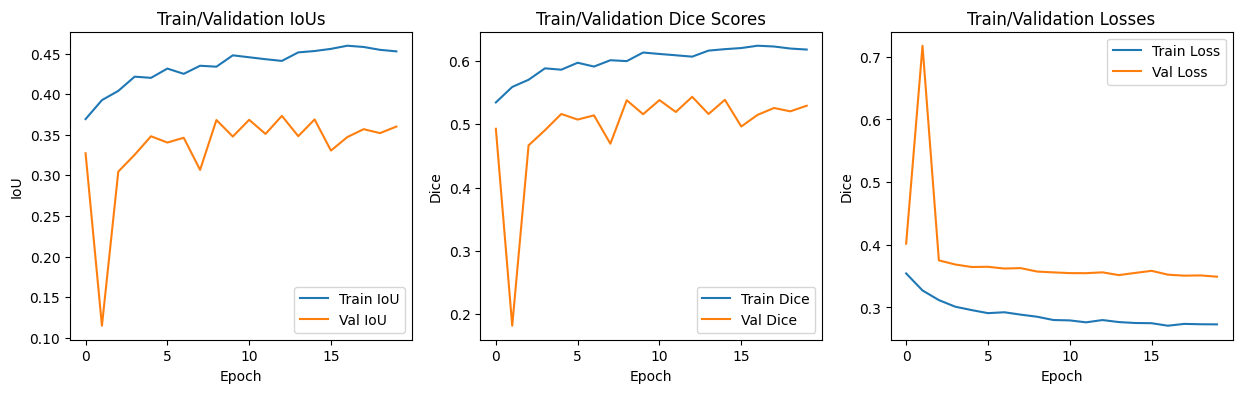

In [ ]:
plt.subplots(1, 3, figsize = (15, 4))

plt.subplot(1, 3, 1)
plt.title("Train/Validation IoUs")
plt.plot(train_ious, label = "Train IoU")
plt.plot(val_ious, label = "Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend();

plt.subplot(1, 3, 2)
plt.title("Train/Validation Dice Scores")
plt.plot(train_dices, label = "Train Dice")
plt.plot(val_dices, label = "Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend();

plt.subplot(1, 3, 3)
plt.title("Train/Validation Losses")
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend();

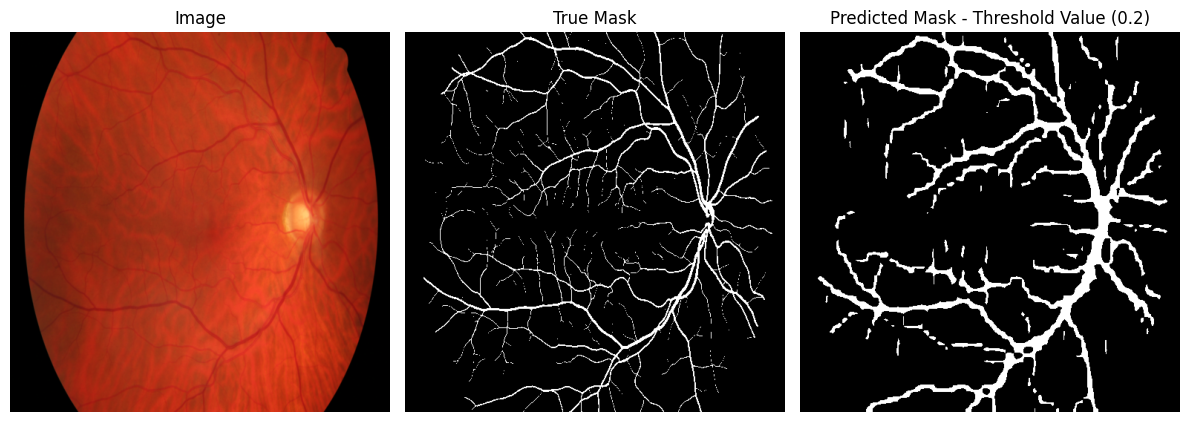

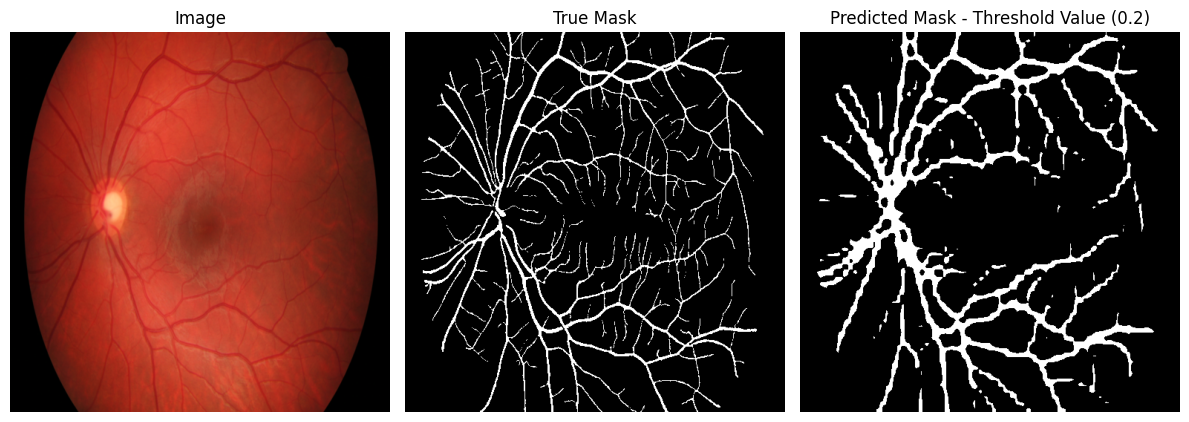

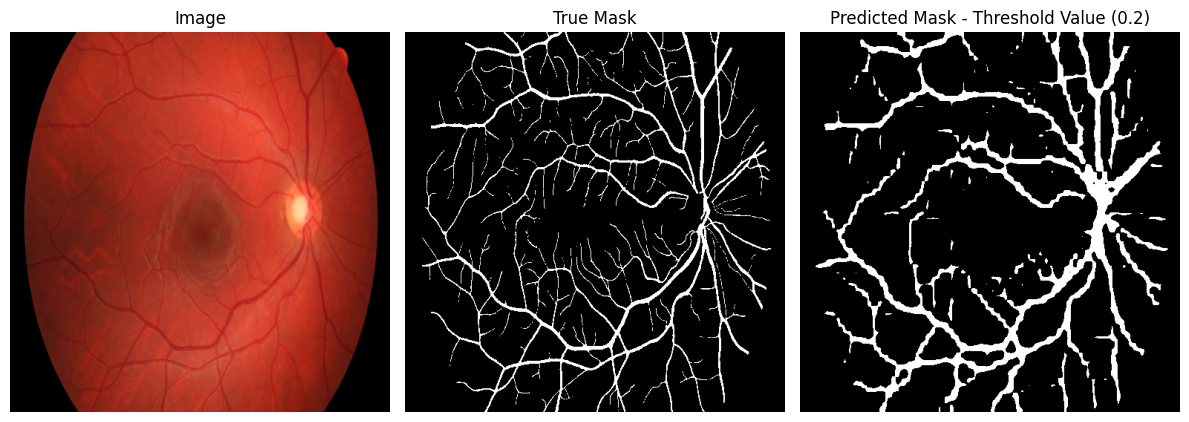

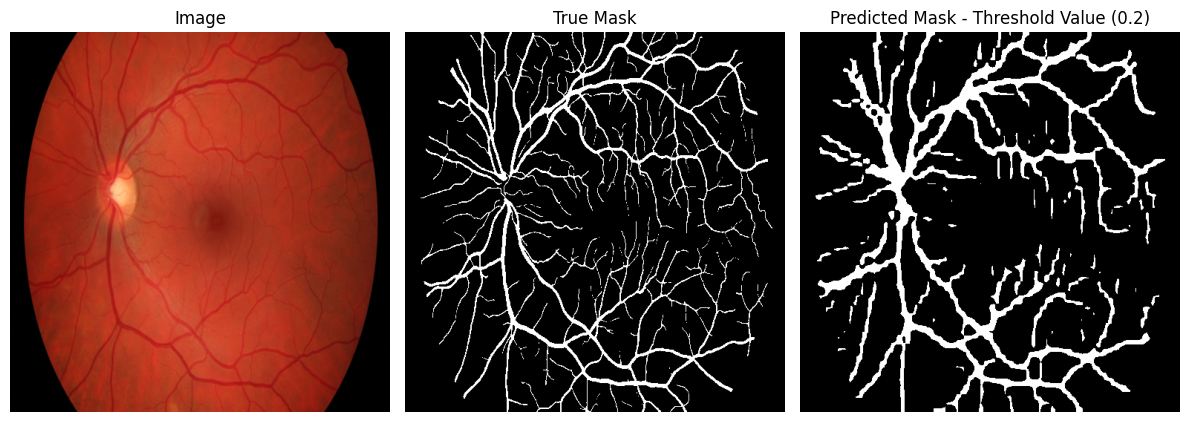

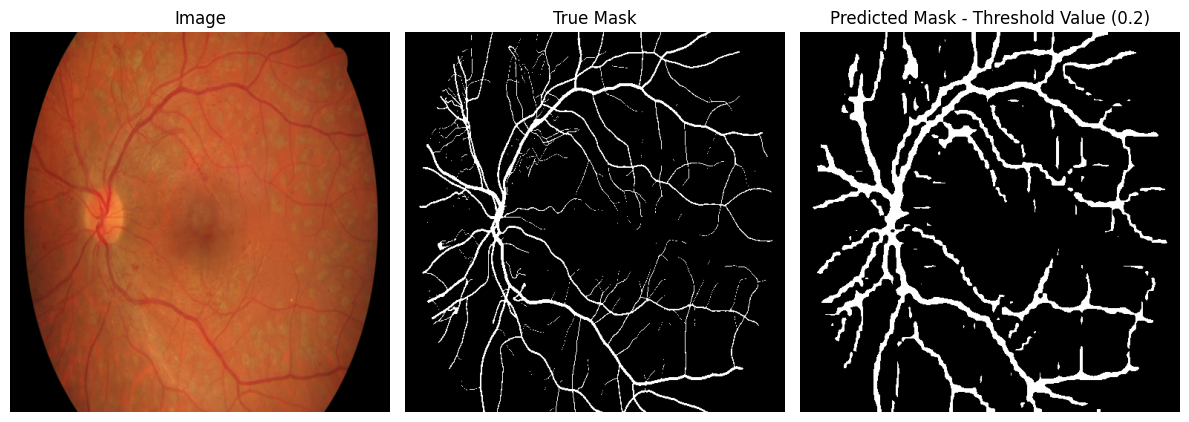

Reached the end of the test_loader.


In [189]:
pred_nd_plot(test_loader, model, device, image_denormalize, pred_threshold = 0.5, num_images = 10)

# Garbage Cleaning.

gc.collect()
# shutil.rmtree(checkpoint_dir)